# Masked Arrays

## What you'll do

Use the masked arrays module from NumPy to analyze COVID-19 data and deal with missing values.

## What you'll learn

- You'll understand what are masked arrays and how they can be created
- You'll see how to access and modify data for masked arrays
- You'll be able to decide when the use of masked arrays is appropriate in some of your applications

## What you'll need

- Basic familiarity with Python. If you would like to refresh your memory, take a look at the [Python tutorial](https://docs.python.org/dev/tutorial/index.html).
- Basic familiarity with NumPy
- To run the plots on your computer, you need [matplotlib](https://matplotlib.org).

***

## What are masked arrays?

Consider the following problem. You have a dataset with missing or invalid entries. If you're doing any kind of processing on this data, and want to *skip* or flag these unwanted entries without just deleting them, you may have to use conditionals or filter your data somehow. The [numpy.ma](https://numpy.org/devdocs/reference/maskedarray.generic.html#module-numpy.ma) module provides some of the same functionality of [NumPy ndarrays](https://numpy.org/devdocs/reference/generated/numpy.ndarray.html#numpy.ndarray) with added structure to ensure invalid entries are not used in computation.

From the [Reference Guide](https://numpy.org/devdocs/reference/maskedarray.generic.html#module-numpy.ma):

> A masked array is the combination of a standard [numpy.ndarray](https://numpy.org/devdocs/reference/generated/numpy.ndarray.html#numpy.ndarray) and a **mask**. A mask is either `nomask`, indicating that no value of the associated array is invalid, or an array of booleans that determines for each element of the associated array whether the value is valid or not. When an element of the mask is `False`, the corresponding element of the associated array is valid and is said to be unmasked. When an element of the mask is `True`, the corresponding element of the associated array is said to be masked (invalid).

We can think of a [MaskedArray](https://numpy.org/devdocs/reference/maskedarray.baseclass.html#numpy.ma.MaskedArray) as a combination of:

- Data, as a regular `numpy.ndarray` of any shape or datatype;
- A boolean mask with the same shape as the data;
- A `fill_value`, a value that may be used to replace the invalid entries in order to return a standard `numpy.ndarray`.

## When can they be useful?

There are a few situations where masked arrays can be more useful than just eliminating the invalid entries of an array:

- When you want to preserve the values you masked for later processing, without copying the array;
- When you have to handle many arrays, each with their own mask. If the mask is part of the array, you avoid bugs and the code is possibly more compact;
- When you have different flags for missing or invalid values, and wish to preserve these flags without replacing them in the original dataset, but exclude them from computations;
- If you can't avoid or eliminate missing values, but don't want to deal with [NaN (Not a Number)](https://numpy.org/devdocs/reference/constants.html#numpy.nan) values in your operations.

Masked arrays are also a good idea since the `numpy.ma` module also comes with a specific implementation of most [NumPy universal functions (ufuncs)](https://numpy.org/devdocs/glossary.html#term-ufunc), which means that you can still apply fast vectorized functions and operations on masked data. The output is then a masked array. We'll see some examples of how this works in practice below.

## Using masked arrays to see COVID-19 data

From [Kaggle](https://www.kaggle.com/atilamadai/covid19) it is possible to download a dataset with initial data about the COVID-19 outbreak in the beginning of 2020. We are going to look at a small subset of this data, contained in the file `who_covid_19_sit_rep_time_series.csv`. *(Note that this file has been replaced with a version without missing data sometime in late 2020.)*

In [1]:
import numpy as np
import os

# The os.getcwd() function returns the current folder; you can change
# the filepath variable to point to the folder where you saved the .csv file
filepath = os.getcwd()
filename = os.path.join(filepath, "who_covid_19_sit_rep_time_series.csv")

The data file contains data of different types and is organized as follows:

- The first row is a header line that (mostly) describes the data in each column that follow in the rows below, and beginning in the fourth column, the header is the date of the observation.
- The second through seventh row contain summary data that is of a different type than that which we are going to examine, so we will need to exclude that from the data with which we will work.
- The numerical data we wish to work with begins at column 4, row 8, and extends from there to the rightmost column and the lowermost row.

Let's explore the data inside this file for the first 14 days of records. To gather data from the `.csv` file, we will use the [numpy.genfromtxt](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) function, making sure we select only the columns with actual numbers instead of the first four columns which contain location data. We also skip the first 6
rows of this file, since they contain other data we are not interested in. Separately, we will extract the information about dates and location for this data.

In [2]:
# Note we are using skip_header and usecols to read only portions of the
# data file into each variable.
# Read just the dates for columns 4-18 from the first row
dates = np.genfromtxt(
    filename,
    dtype=np.str_,
    delimiter=",",
    max_rows=1,
    usecols=range(4, 18),
    encoding="utf-8-sig",
)
# Read the names of the geographic locations from the first two
# columns, skipping the first six rows
locations = np.genfromtxt(
    filename,
    dtype=np.str_,
    delimiter=",",
    skip_header=6,
    usecols=(0, 1),
    encoding="utf-8-sig",
)
# Read the numeric data from just the first 14 days
nbcases = np.genfromtxt(
    filename,
    dtype=np.int_,
    delimiter=",",
    skip_header=6,
    usecols=range(4, 18),
    encoding="utf-8-sig",
)

Included in the `numpy.genfromtxt` function call, we have selected the [numpy.dtype](https://numpy.org/devdocs/reference/generated/numpy.dtype.html#numpy.dtype) for each subset of the data (either an integer - `numpy.int_` - or a string of characters - `numpy.str_`). We have also used the `encoding` argument to select `utf-8-sig` as the encoding for the file (read more about encoding in the [official Python documentation](https://docs.python.org/3/library/codecs.html#encodings-and-unicode). You can read more about the `numpy.genfromtxt` function from the [Reference Documentation](https://numpy.org/devdocs/reference/generated/numpy.genfromtxt.html#numpy.genfromtxt) or from the [Basic IO tutorial](https://numpy.org/devdocs/user/basics.io.genfromtxt.html).

## Exploring the data

First of all, we can plot the whole set of data we have and see what it looks like. In order to get a readable plot, we select only a few of the dates to show in our [x-axis ticks](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xticks.html#matplotlib.pyplot.xticks). Note also that in our plot command, we use `nbcases.T` (the transpose of the `nbcases` array) since this means we will plot each row of the file as a separate line. We choose to plot a dashed line (using the `'--'` line style). See the [matplotlib](https://matplotlib.org/) documentation for more info on this.

Text(0.5, 1.0, 'COVID-19 cumulative cases from Jan 21 to Feb 3 2020')

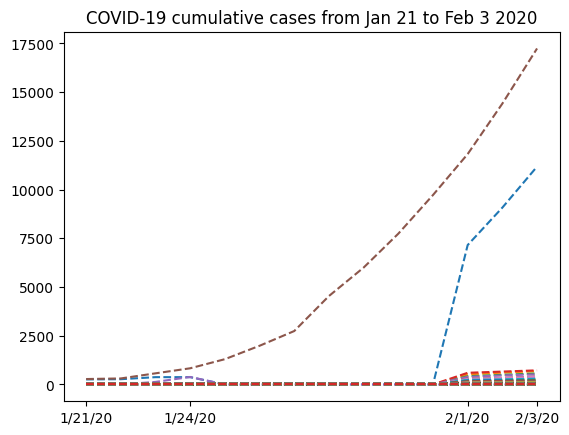

In [3]:
import matplotlib.pyplot as plt

selected_dates = [0, 3, 11, 13]
plt.plot(dates, nbcases.T, "--")
plt.xticks(selected_dates, dates[selected_dates])
plt.title("COVID-19 cumulative cases from Jan 21 to Feb 3 2020")

The graph has a strange shape from January 24th to February 1st. It would be interesting to know where this data comes from. If we look at the `locations` array we extracted from the `.csv` file, we can see that we have two columns, where the first would contain regions and the second would contain the name of the country. However, only the first few rows contain data for the the first column (province names in China). Following that, we only have country names. So it would make sense to group all the data from China into a single row. For this, we'll select from the `nbcases` array only the rows for which the second entry of the `locations` array corresponds to China. Next, we'll use the [numpy.sum](https://numpy.org/devdocs/reference/generated/numpy.sum.html#numpy.sum) function to sum all the selected rows (`axis=0`). Note also that row 35 corresponds to the total counts for the whole country for each date. Since we want to calculate the sum ourselves from the provinces data, we have to remove that row first from both `locations` and `nbcases`:

In [4]:
totals_row = 35
locations = np.delete(locations, (totals_row), axis=0)
nbcases = np.delete(nbcases, (totals_row), axis=0)

china_total = nbcases[locations[:, 1] == "China"].sum(axis=0)
china_total

array([  247,   288,   556,   817,   -22,   -22,   -15,   -10,    -9,
          -7,    -4, 11820, 14410, 17237])

Something's wrong with this data - we are not supposed to have negative values in a cumulative data set. What's going on?

## Missing data

Looking at the data, here's what we find: there is a period with **missing data**:

In [5]:
nbcases

array([[  258,   270,   375, ...,  7153,  9074, 11177],
       [   14,    17,    26, ...,   520,   604,   683],
       [   -1,     1,     1, ...,   422,   493,   566],
       ...,
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1],
       [   -1,    -1,    -1, ...,    -1,    -1,    -1]], shape=(263, 14))

All the `-1` values we are seeing come from `numpy.genfromtxt` attempting to read missing data from the original `.csv` file. Obviously, we
don't want to compute missing data as `-1` - we just want to skip this value so it doesn't interfere in our analysis. After importing the `numpy.ma` module, we'll create a new array, this time masking the invalid values:

In [6]:
from numpy import ma

nbcases_ma = ma.masked_values(nbcases, -1)

If we look at the `nbcases_ma` masked array, this is what we have:

In [7]:
nbcases_ma

masked_array(
  data=[[258, 270, 375, ..., 7153, 9074, 11177],
        [14, 17, 26, ..., 520, 604, 683],
        [--, 1, 1, ..., 422, 493, 566],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-1)

We can see that this is a different kind of array. As mentioned in the introduction, it has three attributes (`data`, `mask` and `fill_value`).
Keep in mind that the `mask` attribute has a `True` value for elements corresponding to **invalid** data (represented by two dashes in the `data` attribute).

Let's try and see what the data looks like excluding the first row (data from the Hubei province in China) so we can look at the missing data more
closely:

Text(0.5, 1.0, 'COVID-19 cumulative cases from Jan 21 to Feb 3 2020')

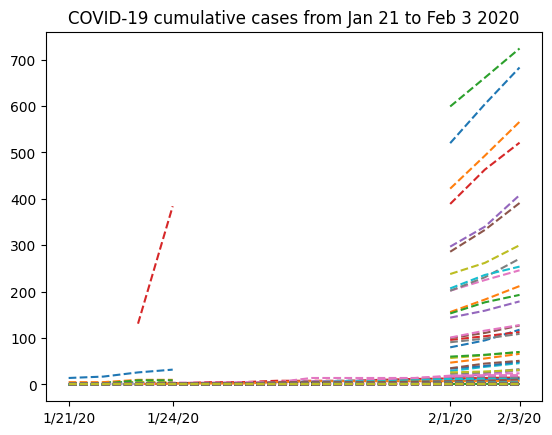

In [8]:
plt.plot(dates, nbcases_ma[1:].T, "--")
plt.xticks(selected_dates, dates[selected_dates])
plt.title("COVID-19 cumulative cases from Jan 21 to Feb 3 2020")

Now that our data has been masked, let's try summing up all the cases in China:

In [9]:
china_masked = nbcases_ma[locations[:, 1] == "China"].sum(axis=0)
china_masked

masked_array(data=[278, 309, 574, 835, 10, 10, 17, 22, 23, 25, 28, 11821,
                   14411, 17238],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False],
       fill_value=999999)

Note that `china_masked` is a masked array, so it has a different data structure than a regular NumPy array. Now, we can access its data directly by using the `.data` attribute:

In [10]:
china_total = china_masked.data
china_total

array([  278,   309,   574,   835,    10,    10,    17,    22,    23,
          25,    28, 11821, 14411, 17238])

That is better: no more negative values. However, we can still see that for some days, the cumulative number of cases seems to go down (from 835 to 10, for example), which does not agree with the definition of "cumulative data". If we look more closely at the data, we can see that in the period where there was missing data in mainland China, there was valid data for Hong Kong, Taiwan, Macau and "Unspecified" regions of China. Maybe we can remove those from the total sum of cases in China, to get a better understanding of the data.

First, we'll identify the indices of locations in mainland China:

In [11]:
china_mask = (
    (locations[:, 1] == "China")
    & (locations[:, 0] != "Hong Kong")
    & (locations[:, 0] != "Taiwan")
    & (locations[:, 0] != "Macau")
    & (locations[:, 0] != "Unspecified*")
)

Now, `china_mask` is an array of boolean values (`True` or `False`); we can check that the indices are what we wanted with the [ma.nonzero](https://numpy.org/devdocs/reference/generated/numpy.ma.nonzero.html#numpy.ma.nonzero) method for masked arrays:

In [12]:
china_mask.nonzero()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 33]),)

Now we can correctly sum entries for mainland China:

In [13]:
china_total = nbcases_ma[china_mask].sum(axis=0)
china_total

masked_array(data=[278, 308, 440, 446, --, --, --, --, --, --, --, 11791,
                   14380, 17205],
             mask=[False, False, False, False,  True,  True,  True,  True,
                    True,  True,  True, False, False, False],
       fill_value=999999)

We can replace the data with this information and plot a new graph, focusing on Mainland China:

Text(0.5, 1.0, 'COVID-19 cumulative cases from Jan 21 to Feb 3 2020 - Mainland China')

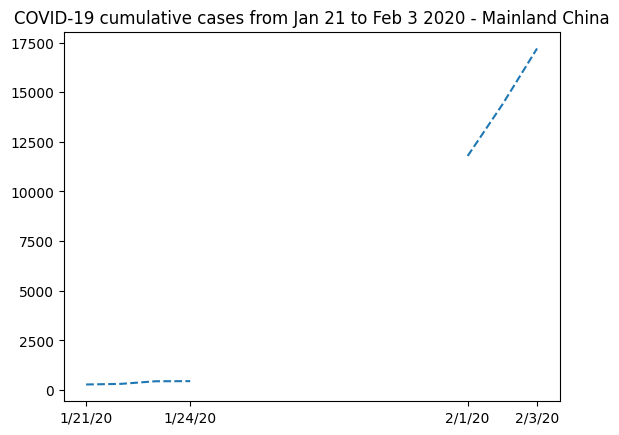

In [14]:
plt.plot(dates, china_total.T, "--")
plt.xticks(selected_dates, dates[selected_dates])
plt.title("COVID-19 cumulative cases from Jan 21 to Feb 3 2020 - Mainland China")

It's clear that masked arrays are the right solution here. We cannot represent the missing data without mischaracterizing the evolution of the curve.

## Fitting Data

One possibility we can think of is to interpolate the missing data to estimate the number of cases in late January. Observe that we can select the masked elements using the `.mask` attribute:

In [15]:
china_total.mask
invalid = china_total[china_total.mask]
invalid

masked_array(data=[--, --, --, --, --, --, --],
             mask=[ True,  True,  True,  True,  True,  True,  True],
       fill_value=999999,
            dtype=int64)

We can also access the valid entries by using the logical negation for this mask:

In [16]:
valid = china_total[~china_total.mask]
valid

masked_array(data=[278, 308, 440, 446, 11791, 14380, 17205],
             mask=[False, False, False, False, False, False, False],
       fill_value=999999)

Now, if we want to create a very simple approximation for this data, we should take into account the valid entries around the invalid ones. So first let's select the dates for which the data is valid. Note that we can use the mask from the `china_total` masked array to index the dates array:

In [17]:
dates[~china_total.mask]

array(['1/21/20', '1/22/20', '1/23/20', '1/24/20', '2/1/20', '2/2/20',
       '2/3/20'], dtype='<U7')

Finally, we can use the
[fitting functionality of the numpy.polynomial](https://numpy.org/doc/stable/reference/generated/numpy.polynomial.polynomial.Polynomial.fit.html)
package to create a cubic polynomial model that fits the data as best as possible:

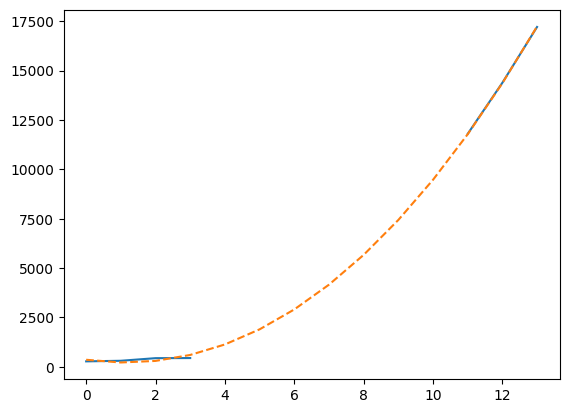

In [18]:
t = np.arange(len(china_total))
model = np.polynomial.Polynomial.fit(t[~china_total.mask], valid, deg=3)
plt.plot(t, china_total)
plt.plot(t, model(t), "--")

This plot is not so readable since the lines seem to be over each other, so let's summarize in a more elaborate plot. We'll plot the real data when
available, and show the cubic fit for unavailable data, using this fit to compute an estimate to the observed number of cases on January 28th 2020, 7 days after the beginning of the records:

Text(0.5, 1.0, 'COVID-19 cumulative cases from Jan 21 to Feb 3 2020 - Mainland China\nCubic estimate for 7 days after start')

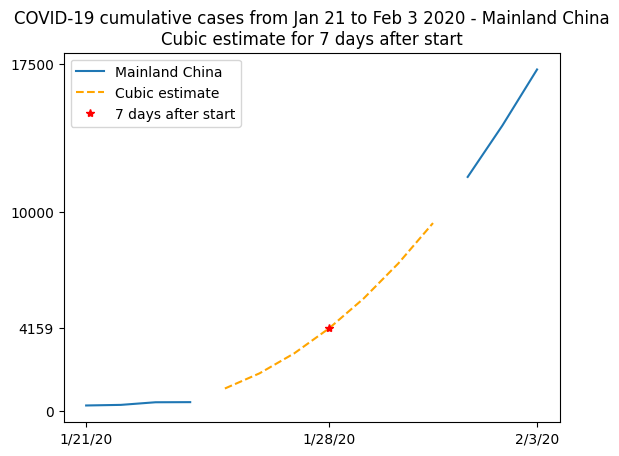

In [19]:
plt.plot(t, china_total)
plt.plot(t[china_total.mask], model(t)[china_total.mask], "--", color="orange")
plt.plot(7, model(7), "r*")
plt.xticks([0, 7, 13], dates[[0, 7, 13]])
plt.yticks([0, model(7), 10000, 17500])
plt.legend(["Mainland China", "Cubic estimate", "7 days after start"])
plt.title(
    "COVID-19 cumulative cases from Jan 21 to Feb 3 2020 - Mainland China\n"
    "Cubic estimate for 7 days after start"
)

## In practice

- Adding `-1` to missing data is not a problem with `numpy.genfromtxt`; in this particular case, substituting the missing value with `0` might have been fine, but we'll see later that this is far from a general solution. Also, it is possible to call the `numpy.genfromtxt` function using the `usemask` parameter. If `usemask=True`, `numpy.genfromtxt` automatically returns a masked array.

## Further reading

Topics not covered in this tutorial can be found in the documentation:

- [Hardmasks](https://numpy.org/devdocs/reference/generated/numpy.ma.harden_mask.html#numpy.ma.harden_mask) vs. [softmasks](https://numpy.org/devdocs/reference/generated/numpy.ma.soften_mask.html#numpy.ma.soften_mask)
- [The numpy.ma module](https://numpy.org/devdocs/reference/maskedarray.generic.html#maskedarray-generic)

### Reference

- Ensheng Dong, Hongru Du, Lauren Gardner, *An interactive web-based dashboard to track COVID-19 in real time*, The Lancet Infectious Diseases, Volume 20, Issue 5, 2020, Pages 533-534, ISSN 1473-3099, [https://doi.org/10.1016/S1473-3099(20)30120-1](https://doi.org/10.1016/S1473-3099(20)30120-1).